In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
tickers = ['BAH', 'NOC', 'PLTR']
start_date = '2020-01-01'
end_date = '2025-06-30'

data = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = data.pct_change().dropna()

/var/folders/cz/l5s8bjb52v555tv67llq0j1c0000gn/T/ipykernel_40351/3601481619.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


In [4]:
daily_mean = returns.mean()
annualized_return = daily_mean * 252
annualized_vol = returns.std() * np.sqrt(252)

asset_stats = pd.DataFrame({
    'Mean Daily Return': daily_mean,
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_vol
})
print("Asset Summary Statistics:\n")
print(asset_stats.to_string(float_format='%.4f'))

Asset Summary Statistics:

        Mean Daily Return  Annualized Return  Annualized Volatility
Ticker                                                             
BAH                0.0004             0.1034                 0.2841
NOC                0.0006             0.1419                 0.2451
PLTR               0.0032             0.8145                 0.7298


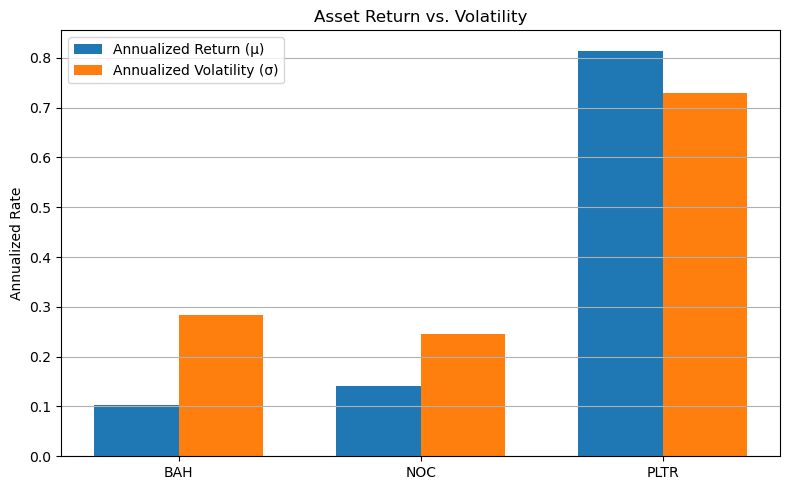

In [5]:
tickers = returns.columns
x = np.arange(len(tickers))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, annualized_return, width, label='Annualized Return (μ)')
bar2 = ax.bar(x + width/2, annualized_vol, width, label='Annualized Volatility (σ)')

ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.set_ylabel('Annualized Rate')
ax.set_title('Asset Return vs. Volatility')
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [6]:
mu = annualized_return.values
cov = returns.cov().values * 252

In [7]:
n_portfolios = 1000
max_leverage = 2.0
risk_free_rate = 0.03

mu_pi_long, sigma_pi_long, long_only_weights = [], [], []
mu_pi_longshort, sigma_pi_longshort, long_short_weights = [], [], []

In [8]:
while len(mu_pi_long) < n_portfolios:
    w = np.random.rand(2)
    w3 = 1 - np.sum(w)
    if w3 >= 0:
        w = np.append(w, w3)
        port_return = np.dot(w, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        mu_pi_long.append(port_return)
        sigma_pi_long.append(port_vol)
        long_only_weights.append(w)

In [9]:
while len(mu_pi_longshort) < n_portfolios:
    w = np.random.randn(3)
    w = w / np.sum(w)
    if np.sum(np.abs(w)) <= max_leverage:
        port_return = np.dot(w, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov, w)))
        mu_pi_longshort.append(port_return)
        sigma_pi_longshort.append(port_vol)
        long_short_weights.append(w)

In [10]:
mu_pi_long = np.array(mu_pi_long)
sigma_pi_long = np.array(sigma_pi_long)
mu_pi_longshort = np.array(mu_pi_longshort)
sigma_pi_longshort = np.array(sigma_pi_longshort)

In [11]:
sharpe_long = (mu_pi_long - risk_free_rate) / sigma_pi_long
sharpe_longshort = (mu_pi_longshort - risk_free_rate) / sigma_pi_longshort

idx_max_sharpe_long = np.argmax(sharpe_long)
idx_min_risk_long = np.argmin(sigma_pi_long)
idx_max_sharpe_longshort = np.argmax(sharpe_longshort)
idx_min_risk_longshort = np.argmin(sigma_pi_longshort)

optimal_long_only_weights = {
    'Max Sharpe': long_only_weights[idx_max_sharpe_long],
    'Min Risk': long_only_weights[idx_min_risk_long]
}
optimal_long_short_weights = {
    'Max Sharpe': long_short_weights[idx_max_sharpe_longshort],
    'Min Risk': long_short_weights[idx_min_risk_longshort]
}

In [12]:
sigma_range = np.linspace(
    min(sigma_pi_long.min(), sigma_pi_longshort.min()),
    max(sigma_pi_long.max(), sigma_pi_longshort.max()), 500
)

poly_long = np.polyfit(sigma_pi_long, mu_pi_long, 3)
ef_long = np.polyval(poly_long, sigma_range)

poly_short = np.polyfit(sigma_pi_longshort, mu_pi_longshort, 3)
ef_short = np.polyval(poly_short, sigma_range)

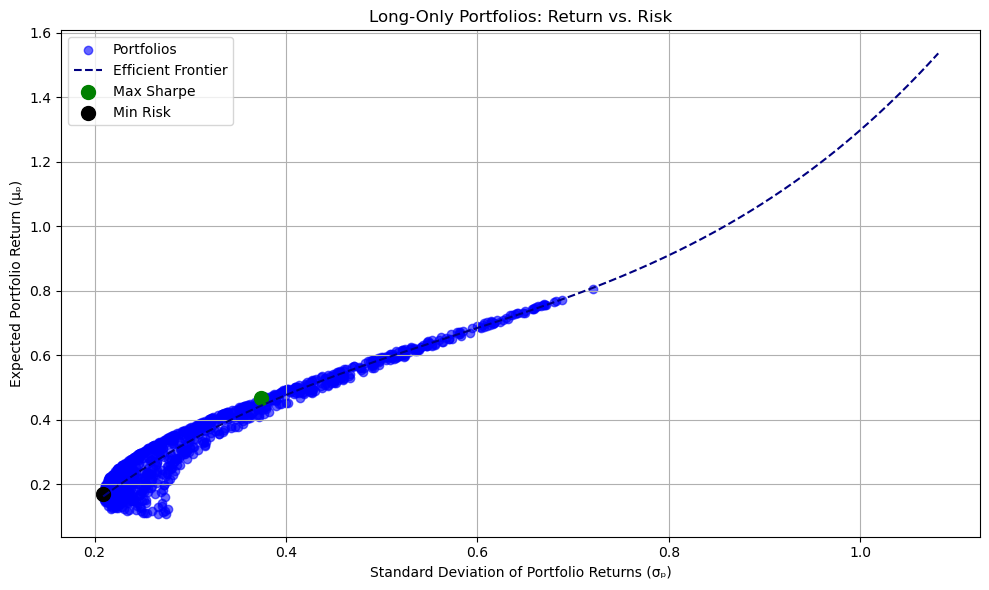

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(sigma_pi_long, mu_pi_long, alpha=0.6, color='blue', label='Portfolios')
plt.plot(sigma_range, ef_long, color='navy', linestyle='--', label='Efficient Frontier')
plt.scatter(sigma_pi_long[idx_max_sharpe_long], mu_pi_long[idx_max_sharpe_long], color='green', s=100, label='Max Sharpe')
plt.scatter(sigma_pi_long[idx_min_risk_long], mu_pi_long[idx_min_risk_long], color='black', s=100, label='Min Risk')
plt.xlabel('Standard Deviation of Portfolio Returns (σₚ)')
plt.ylabel('Expected Portfolio Return (μₚ)')
plt.title('Long-Only Portfolios: Return vs. Risk')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

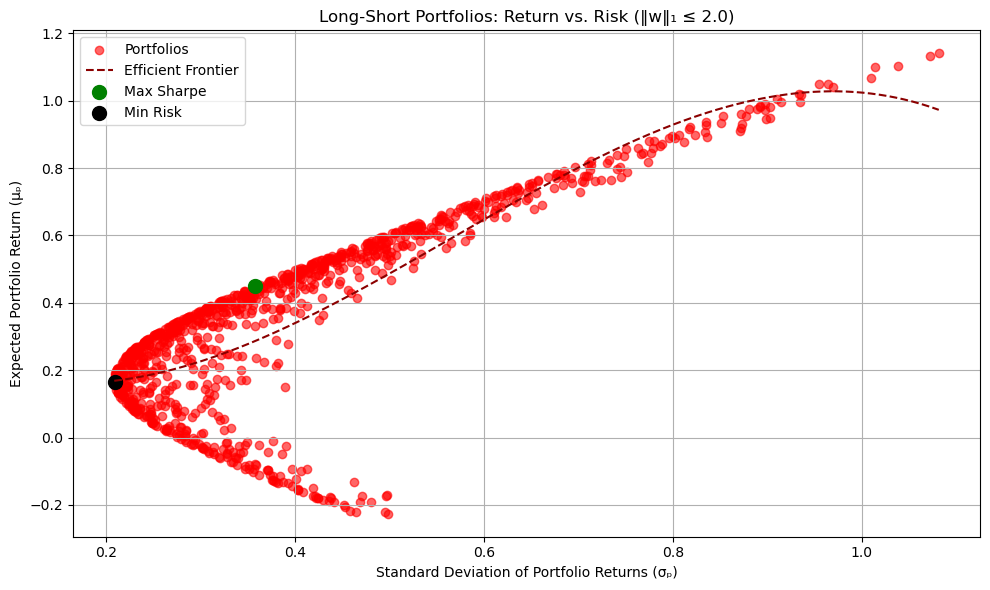

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(sigma_pi_longshort, mu_pi_longshort, alpha=0.6, color='red', label='Portfolios')
plt.plot(sigma_range, ef_short, color='darkred', linestyle='--', label='Efficient Frontier')
plt.scatter(sigma_pi_longshort[idx_max_sharpe_longshort], mu_pi_longshort[idx_max_sharpe_longshort], color='green', s=100, label='Max Sharpe')
plt.scatter(sigma_pi_longshort[idx_min_risk_longshort], mu_pi_longshort[idx_min_risk_longshort], color='black', s=100, label='Min Risk')
plt.xlabel('Standard Deviation of Portfolio Returns (σₚ)')
plt.ylabel('Expected Portfolio Return (μₚ)')
plt.title('Long-Short Portfolios: Return vs. Risk (‖w‖₁ ≤ 2.0)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Long-Only (Max Sharpe)': optimal_long_only_weights['Max Sharpe'],
    'Long-Only (Min Risk)': optimal_long_only_weights['Min Risk'],
    'Long-Short (Max Sharpe)': optimal_long_short_weights['Max Sharpe'],
    'Long-Short (Min Risk)': optimal_long_short_weights['Min Risk']
})

print("Optimal Portfolio Weights:")
print(weights_df.to_string(index=False, float_format="%.4f"))

Optimal Portfolio Weights:
Ticker  Long-Only (Max Sharpe)  Long-Only (Min Risk)  Long-Short (Max Sharpe)  Long-Short (Min Risk)
   BAH                  0.0070                0.3506                  -0.0546                 0.3868
   NOC                  0.5107                0.5899                   0.6013                 0.5561
  PLTR                  0.4823                0.0595                   0.4533                 0.0572


In [16]:
price_data = data.copy()
price_data.index.name = "Date"
price_data.to_csv("yfinance_price_data.csv")

portfolio_df = pd.concat([
    pd.DataFrame({'Strategy': 'Long-Only', 'Return': mu_pi_long, 'Risk': sigma_pi_long}),
    pd.DataFrame({'Strategy': 'Long-Short', 'Return': mu_pi_longshort, 'Risk': sigma_pi_longshort})
])
portfolio_df.to_csv("portfolio_simulation_results.csv", index=False)

In [17]:
# Number of scenarios
n_scenarios = 1000
np.random.seed(42)

# Simulate future return scenarios from the multivariate normal
scenario_returns = np.random.multivariate_normal(mu, cov, size=n_scenarios)

In [18]:
# Generate candidate portfolios
n_candidates = 10000
candidate_weights = []

while len(candidate_weights) < n_candidates:
    w = np.random.rand(len(mu))
    w /= np.sum(w)
    if np.all(w >= 0) and np.all(w <= 1):  # long-only
        candidate_weights.append(w)

candidate_weights = np.array(candidate_weights)

In [19]:
portfolio_returns = scenario_returns @ candidate_weights.T
expected_returns = portfolio_returns.mean(axis=0)
volatility = portfolio_returns.std(axis=0)
sharpe_ratios = (expected_returns - 0.03) / volatility

In [20]:
# Find optimal weights
idx_max_sharpe = np.argmax(sharpe_ratios)
idx_min_risk = np.argmin(volatility)

print("Stochastic Programming Approximation (Monte Carlo)")
print("Max Sharpe Portfolio Weights:")
for i, name in enumerate(tickers):
    print(f"{name}: {candidate_weights[idx_max_sharpe][i]:.4f}")
print(f"Expected Return: {expected_returns[idx_max_sharpe]:.4f}")
print(f"Volatility: {volatility[idx_max_sharpe]:.4f}")
print(f"Sharpe Ratio: {sharpe_ratios[idx_max_sharpe]:.4f}")

Stochastic Programming Approximation (Monte Carlo)
Max Sharpe Portfolio Weights:
BAH: 0.0029
NOC: 0.5937
PLTR: 0.4035
Expected Return: 0.4024
Volatility: 0.3170
Sharpe Ratio: 1.1748


In [21]:
max_sharpe_weights = pd.Series(candidate_weights[idx_max_sharpe], index=returns.columns)
weighted_returns = returns @ max_sharpe_weights
cumulative_returns = (1 + weighted_returns).cumprod()

In [22]:
sp500 = yf.download('^GSPC', start=returns.index.min(), end=returns.index.max())['Close']
sp500 = sp500.pct_change().dropna()
sp500 = sp500.reindex(cumulative_returns.index).fillna(method='ffill')
sp500_cum = (1 + sp500).cumprod()

/var/folders/cz/l5s8bjb52v555tv67llq0j1c0000gn/T/ipykernel_40351/698336255.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=returns.index.min(), end=returns.index.max())['Close']
[*********************100%***********************]  1 of 1 completed
/var/folders/cz/l5s8bjb52v555tv67llq0j1c0000gn/T/ipykernel_40351/698336255.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp500 = sp500.reindex(cumulative_returns.index).fillna(method='ffill')


In [23]:
max_sharpe_return = ((cumulative_returns.iloc[-1] - 1) * 100).item()
sp500_return = ((sp500_cum.iloc[-1] - 1) * 100).item()

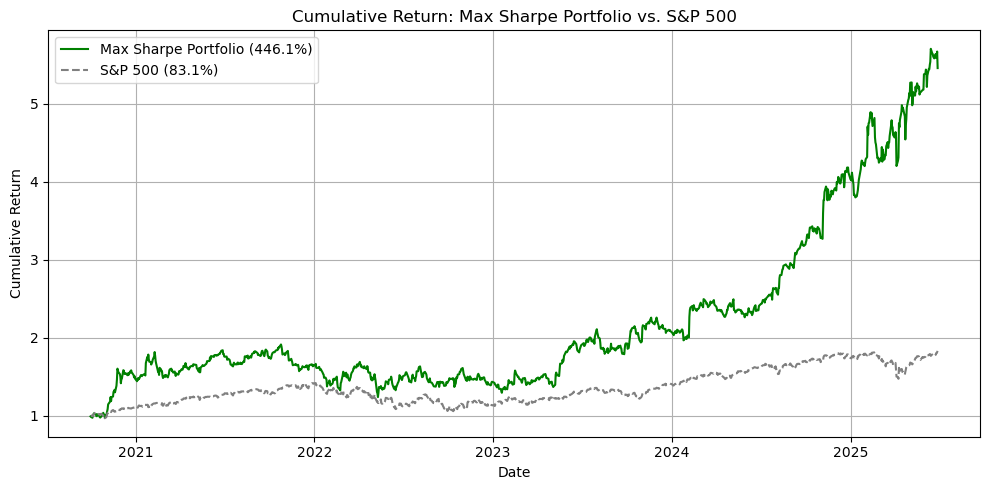

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns.index, cumulative_returns, 
         label=f'Max Sharpe Portfolio ({max_sharpe_return:.1f}%)', color='green')
plt.plot(sp500_cum.index, sp500_cum, 
         label=f'S&P 500 ({sp500_return:.1f}%)', color='gray', linestyle='--')

plt.title('Cumulative Return: Max Sharpe Portfolio vs. S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()